## Import necessary libraries 

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet152
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, DeiTForImageClassification
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

## Seeding

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Image dataset

In [ ]:
def load_and_preprocess_data(data_dir, target_size=(224, 224)):

    X = []

    # Sort filenames to maintain the default order
    for img_name in sorted(os.listdir(data_dir)):
        img_path = os.path.join(data_dir, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')  
                img = img.resize(target_size)  
                X.append(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return X

data_dir = '/kaggle/input/mammography/DMID_malignant_non-malignant/DMID_malignant_non-malignant'
X = load_and_preprocess_data(data_dir)

## Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Text dataset

In [ ]:
# Path to the CSV file
file_path = "/kaggle/input/mammography/mammography-text.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(file_path)

## Annotation

In [ ]:
images = X
label_mapping = {'Non-Malignant': 0, 'Malignant': 1}
labels = df['Class'].map(label_mapping).values
texts = df['Generated Sentence'].tolist()

## Class weights

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=torch.unique(torch.tensor(labels)).numpy(),
    y=labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

print(f"Class Weights on Device: {class_weights_tensor}")

Class Weights on Device: tensor([0.6711, 1.9615], device='cuda:0')


## Multimodal dataset

In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, image_data, text_data, labels, tokenizer, transform=None, max_text_length=512):

        self.image_data = image_data
        self.text_data = text_data
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_text_length = max_text_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Image data
        image = self.image_data[idx]
        if self.transform:
            image = self.transform(image)
        
        # Text data
        text = self.text_data[idx]
        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=self.max_text_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        # Flatten input IDs and attention masks
        input_ids = encoded_text["input_ids"].flatten()
        attention_mask = encoded_text["attention_mask"].flatten()

        # Labels
        label = self.labels[idx]

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label
        }

## Bidirectional Gated Cross-Attention

In [ ]:
class GatedCrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, hidden_dim):
        super(GatedCrossAttention, self).__init__()
        self.query_proj = nn.Linear(query_dim, hidden_dim)
        self.key_proj = nn.Linear(context_dim, hidden_dim)
        self.value_proj = nn.Linear(context_dim, hidden_dim)

        # Gating mechanism
        self.gate_fc = nn.Linear(query_dim + hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, context):
        Q = self.query_proj(query).unsqueeze(1)     # [B, 1, H]
        K = self.key_proj(context).unsqueeze(1)     # [B, 1, H]
        V = self.value_proj(context).unsqueeze(1)   # [B, 1, H]

        attn_scores = torch.bmm(Q, K.transpose(1, 2))  # [B, 1, 1]
        attn_weights = self.softmax(attn_scores)       # [B, 1, 1]
        attended = torch.bmm(attn_weights, V).squeeze(1)  # [B, H]

        # Project query into hidden space for fusion
        query_proj = self.query_proj(query)  # [B, H]

        # Gate computation
        gate_input = torch.cat([query, attended], dim=1)  # [B, Q+H]
        gate = self.sigmoid(self.gate_fc(gate_input))     # [B, H]

        # Gated fusion
        gated_output = gate * query_proj + (1 - gate) * attended  # [B, H]
        return gated_output

## Multimodal model

In [ ]:
class MultiModalModelGatedCrossAttention(nn.Module):
    def __init__(self, resnet_model, deit_model, text_model, fc_network):
        super(MultiModalModelGatedCrossAttention, self).__init__()
        self.resnet_model = resnet_model
        self.deit_model = deit_model
        self.text_model = text_model

        self.resnet_dim = 2048
        self.deit_dim = 768
        self.text_dim = 768

        self.fc_network = fc_network

        self.vision_dim = self.resnet_dim + self.deit_dim
        self.hidden_dim = 512  

        # Gated cross attention: both directions
        self.text_to_vision = GatedCrossAttention(self.text_dim, self.vision_dim, self.hidden_dim)
        self.vision_to_text = GatedCrossAttention(self.vision_dim, self.text_dim, self.hidden_dim)

    def forward(self, image_input, input_ids, attention_mask):

        # Extract image features
        resnet_features = self.resnet_model(image_input)                  # [B, 2048]
        deit_features = self.deit_model(image_input).logits              # [B, 768]
        vision_features = torch.cat([resnet_features, deit_features], dim=1)  # [B, 2816]

        # Extract text features from [CLS] token of last hidden state
        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        text_features = text_outputs.hidden_states[-1][:, 0, :]          # [B, 768]

        # Gated Cross Attention both directions
        enhanced_text = self.text_to_vision(text_features, vision_features)    # [B, 512]
        enhanced_vision = self.vision_to_text(vision_features, text_features)  # [B, 512]

        # Final fused representation
        fused = torch.cat([enhanced_text, enhanced_vision], dim=1)       # [B, 1024]

        output = self.fc_network(fused)
        return output

## Train loop

In [ ]:
def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc="Training"):

        # Move data to the device
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Step the scheduler every epoch
    scheduler.step()

    return epoch_loss, epoch_accuracy

## Evaluation loop

In [ ]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad(): 
        for batch in tqdm(val_loader, desc="Validation"):

            # Move data to the device
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            predictions.extend(preds)
            true_labels.extend(labels)

    predictions = torch.stack(predictions).cpu()
    true_labels = torch.stack(true_labels).cpu()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy, classification_report(
        true_labels, predictions, target_names=df['Class'].unique(), output_dict=True
    )

## Confusion matrix

In [ ]:
def generate_confusion_matrix(true_labels, predictions, save_cm_path, class_names=['Non-malignant', 'Malignant']):

    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_cm_path), exist_ok=True)

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, linewidths=2, cbar=False, square=True, annot_kws={"size": 14})
    
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)

    # Save confusion matrix as PDF
    plt.savefig(save_cm_path, bbox_inches="tight", format="pdf")
    plt.close()
    print(f"Confusion matrix saved as {save_cm_path}")

    # Return classification report
    return classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

## Test loop

In [21]:
def test_model(model, val_loader, criterion, device, seed=None, report_save_path=None):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluation"):
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            predictions.extend(preds.cpu())
            true_labels.extend(labels.cpu())

            probs = torch.softmax(outputs, dim=1)
            probabilities.extend(probs.cpu())

    predictions = torch.stack(predictions)
    true_labels = torch.stack(true_labels)
    probabilities = torch.stack(probabilities)

    # Metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    auc_roc = roc_auc_score(true_labels, probabilities[:, 1], multi_class="ovr") if probabilities.shape[1] > 1 else None

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion matrix
    save_cm_path = '/kaggle/working/confusion_matrix.pdf'
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-malignant', 'Malignant'],
                yticklabels=['Non-malignant', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(save_cm_path)
    plt.show()

    # Classification Report
    class_report = classification_report(
        true_labels,
        predictions,
        target_names=['Non-malignant', 'Malignant'],
        output_dict=True
    )

    # Return metrics summary and full classification report
    results_df = pd.DataFrame([{
        'Seed': seed if seed is not None else 'N/A',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }])

    return results_df, class_report

## Fully connected network

In [ ]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim // 2, output_dim)            
        )

    def forward(self, x):
        return self.fc(x)

In [26]:
# Define model dimensions
input_dim = 1024  # Refined features
hidden_dim = 512
output_dim = 2  # Number of classes (Non-malignant, Malignant)

# Initialize the fully connected network
fc_network = FullyConnectedNetwork(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim
)

## Multimodal learning (ResNet152+Deit+BioBERT)

In [ ]:
# Load the pretrained ResNet152 model
def load_resnet_model(weight_path):

    resnet_model = resnet152(pretrained=False)
    num_features = resnet_model.fc.in_features
    resnet_model.fc = torch.nn.Identity()  
    
    # Load the state_dict
    state_dict = torch.load(weight_path)
    
    # Remove "fc.weight" and "fc.bias" from the state_dict
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}
    
    # Load the pruned state_dict into the model
    resnet_model.load_state_dict(state_dict, strict=False)
    resnet_model.eval()  # Set to evaluation mode
    
    for param in resnet_model.parameters():
        param.requires_grad = False  # Freeze all parameters
    
    return resnet_model


# Load the pretrained DeiT model
def load_deit_model(weight_path, num_classes=2):

    deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224")
    
    # Remove classifier for feature extraction
    deit_model.classifier = nn.Identity()  

    # Load trained weights
    state_dict = torch.load(weight_path, map_location=torch.device('cpu'))
    deit_model.load_state_dict(state_dict, strict=False)

    # Set model to evaluation mode
    deit_model.eval()

    # Freeze parameters
    for param in deit_model.parameters():
        param.requires_grad = False  

    return deit_model
    

# Load the pretrained BioBERT model
def load_bert_model(weight_path, bert_model_name='dmis-lab/biobert-v1.1'):
    
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    
    # Initialize the model with the same configuration used during training
    bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=2)  

    # Load the state_dict into the model
    state_dict = torch.load(weight_path, map_location=torch.device('cpu'))  

    # Load the state dict into the model 
    bert_model.load_state_dict(state_dict, strict=False)

    # Set the model to evaluation mode
    bert_model.eval()

    # Freeze the parameters of the model (for feature extraction)
    for param in bert_model.parameters():
        param.requires_grad = False

    return bert_model, tokenizer

# Paths to saved model weights
resnet_weight_path = "/kaggle/input/resnet152-best-model-mammo/pytorch/default/resnet_best_model.pth"
deit_weight_path = "/kaggle/input/deit-mammo/pytorch/default/deit_best_model.pth"
bert_weight_path = "/kaggle/input/biobert-best-model-mammo/pytorch/default/best_bio_model_state2.bin"

# Load the pretrained models for feature extraction
resnet_model = load_resnet_model(resnet_weight_path)
deit_model = load_deit_model(deit_weight_path)
text_model, bert_tokenizer = load_bert_model(bert_weight_path)

print("Models loaded and ready for feature extraction.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-40-7c9a3dacf91b>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Models loaded and ready for feature extraction.


## Experiments across 10 different seeds

In [ ]:
def run_experiments_over_seeds_multimodal(seed_list, texts, images, labels,
                                          train_transform, val_test_transform,
                                          resnet_weight_path, deit_weight_path, bert_weight_path,
                                          fc_network, class_weights_tensor):

    test_reports = []
    test_auc_roc = []

    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for iteration, seed in enumerate(seed_list):
        print(f"\n🔁 Running experiment with seed: {seed}")
        set_seed(seed)

        def seed_worker(worker_id):
            np.random.seed(seed)
            random.seed(seed)

        # === STEP 1: Load the models ===
        resnet_model = load_resnet_model(resnet_weight_path)
        deit_model = load_deit_model(deit_weight_path)
        text_model, bert_tokenizer = load_bert_model(bert_weight_path)

        # === STEP 2: Data split ===
        texts_train_val, texts_test, images_train_val, images_test, labels_train_val, labels_test = train_test_split(
            texts, images, labels, test_size=0.15, stratify=labels, random_state=seed
        )
        texts_train, texts_val, images_train, images_val, labels_train, labels_val = train_test_split(
            texts_train_val, images_train_val, labels_train_val, test_size=0.176,
            stratify=labels_train_val, random_state=seed
        )

        # === STEP 3: Create datasets and dataloaders ===
        train_dataset = MultiModalDataset(images_train, texts_train, labels_train, bert_tokenizer, train_transform, 512)
        val_dataset = MultiModalDataset(images_val, texts_val, labels_val, bert_tokenizer, val_test_transform, 512)
        test_dataset = MultiModalDataset(images_test, texts_test, labels_test, bert_tokenizer, val_test_transform, 512)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker)

        # === STEP 4: Initialize model and training tools ===
        model = MultiModalModelGatedCrossAttention(
            resnet_model, deit_model, text_model, fc_network
        ).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
        optimizer = Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-5, weight_decay=1e-4
        )
        scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

        # === STEP 5: Train with Early Stopping ===
        best_val_f1 = 0
        patience_counter = 0
        patience_limit = 10
        num_epochs = 50

        mm_train_losses = []
        mm_val_losses = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, device)
            val_loss, val_acc, val_report = evaluate_model(model, val_loader, criterion, device)

            mm_train_losses.append(train_loss)
            mm_val_losses.append(val_loss)

            val_f1 = val_report['macro avg']['f1-score']
            print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
                print("✅ Improved F1. Saving model...")
            else:
                patience_counter += 1
                if patience_counter >= patience_limit:
                    print("🛑 Early stopping triggered.")
                    break

        # === STEP 6: Load best model and test ===
        model.load_state_dict(best_model_state)
        results_df, class_report = test_model(model, test_loader, criterion, device, seed=seed)

        test_reports.append(class_report)
        test_auc_roc.append(results_df["AUC-ROC"].values[0])

        # === STEP 7: Plot loss curves ===
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(mm_train_losses) + 1), mm_train_losses, label='Training Loss')
        plt.plot(range(1, len(mm_val_losses) + 1), mm_val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Seed {seed} - Training and Validation Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return test_reports, test_auc_roc


🔁 Running experiment with seed: 42


<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weight_path)
Some weights of DeiTForImageClassification were not in

Epoch 1: Train Acc=0.6826, Val Acc=0.9221, Val F1=0.9045
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Epoch 2: Train Acc=0.8820, Val Acc=0.9351, Val F1=0.9193
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Epoch 3: Train Acc=0.9185, Val Acc=0.9481, Val F1=0.9345
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Epoch 4: Train Acc=0.9213, Val Acc=0.9740, Val F1=0.9662
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Epoch 5: Train Acc=0.9410, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 6: Train Acc=0.9494, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9466, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 8: Train Acc=0.9466, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 9: Train Acc=0.9354, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 10: Train Acc=0.9185, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9494, Val Acc=0.9610, Val F1=0.9501


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 12: Train Acc=0.9410, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 13: Train Acc=0.9410, Val Acc=0.9740, Val F1=0.9662


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


Epoch 14: Train Acc=0.9213, Val Acc=0.9740, Val F1=0.9662
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000


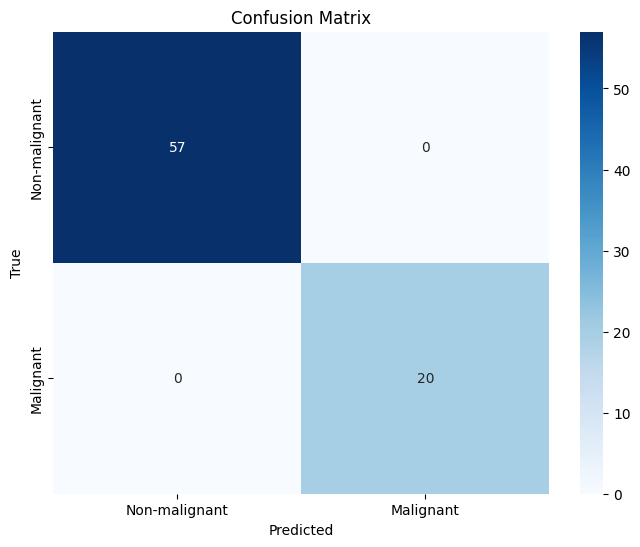

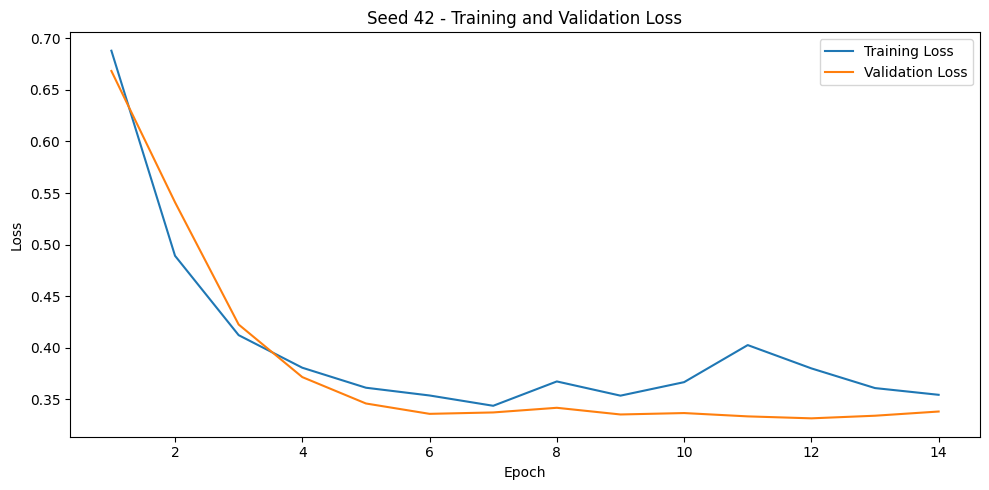


🔁 Running experiment with seed: 77


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7556, Val Acc=0.9481, Val F1=0.9301
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 2: Train Acc=0.9213, Val Acc=0.9481, Val F1=0.9301


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 3: Train Acc=0.9270, Val Acc=0.9870, Val F1=0.9834
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 4: Train Acc=0.9382, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 5: Train Acc=0.9326, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 6: Train Acc=0.9410, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 8: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 9: Train Acc=0.9354, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 12: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 13: Train Acc=0.9466, Val Acc=0.9870, Val F1=0.9834
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Accuracy: 0.9610
Precision: 0.9435
Recall: 0.9575
F1 Score: 0.9501
AUC-ROC: 0.9965


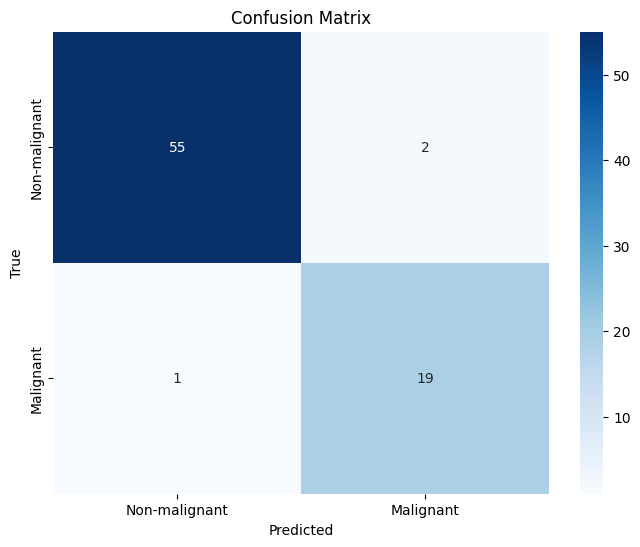

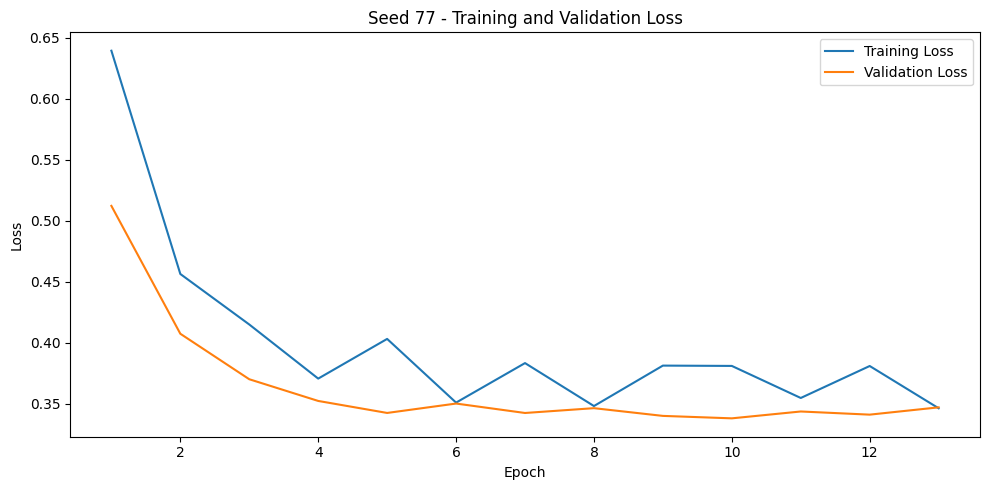


🔁 Running experiment with seed: 7


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.6882, Val Acc=0.9610, Val F1=0.9501
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 2: Train Acc=0.9129, Val Acc=0.9870, Val F1=0.9834
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 3: Train Acc=0.9213, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 4: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 5: Train Acc=0.9354, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 6: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9438, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 8: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 9: Train Acc=0.9663, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Epoch 10: Train Acc=0.9410, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 11: Train Acc=0.9410, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 12: Train Acc=0.9607, Val Acc=0.9870, Val F1=0.9834
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Accuracy: 0.9351
Precision: 0.9215
Recall: 0.9075
F1 Score: 0.9142
AUC-ROC: 0.9851


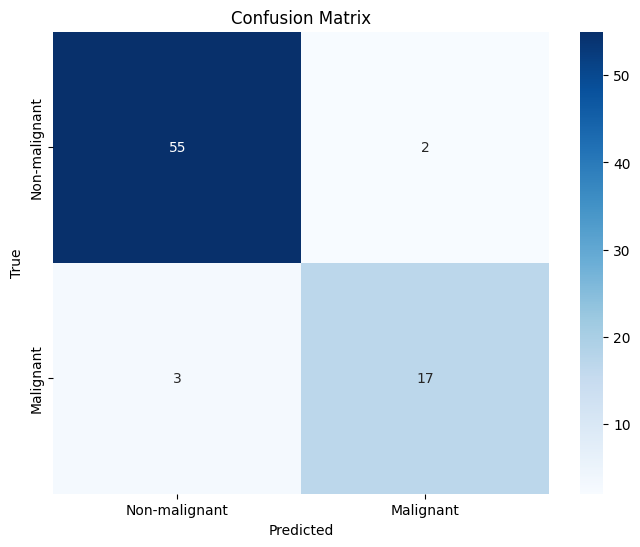

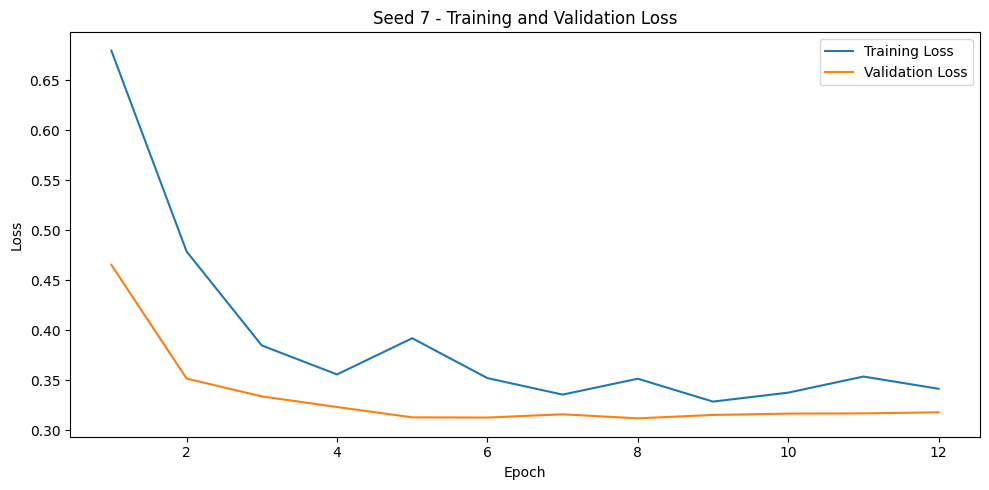


🔁 Running experiment with seed: 101


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7416, Val Acc=0.9740, Val F1=0.9662
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 2: Train Acc=0.8989, Val Acc=0.9740, Val F1=0.9673
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 3: Train Acc=0.9045, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 4: Train Acc=0.9270, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 5: Train Acc=0.9382, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 6: Train Acc=0.9298, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9438, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 8: Train Acc=0.9382, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 9: Train Acc=0.9354, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9410, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 11: Train Acc=0.9466, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 12: Train Acc=0.9354, Val Acc=0.9740, Val F1=0.9673
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Accuracy: 0.9610
Precision: 0.9435
Recall: 0.9575
F1 Score: 0.9501
AUC-ROC: 0.9930


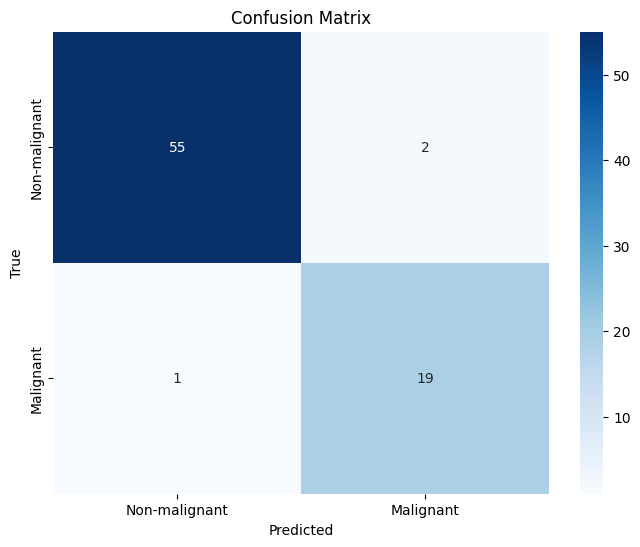

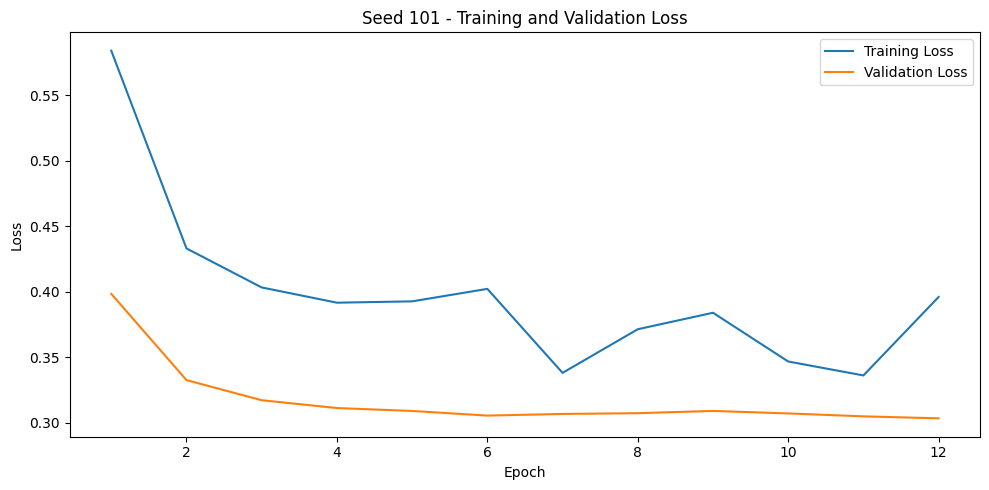


🔁 Running experiment with seed: 314


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7528, Val Acc=0.9740, Val F1=0.9673
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 2: Train Acc=0.9157, Val Acc=0.9870, Val F1=0.9834
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 3: Train Acc=0.9326, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 4: Train Acc=0.9242, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 5: Train Acc=0.9298, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 6: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 8: Train Acc=0.9466, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 9: Train Acc=0.9466, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 10: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9494, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 12: Train Acc=0.9607, Val Acc=0.9870, Val F1=0.9834
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Accuracy: 0.9610
Precision: 0.9435
Recall: 0.9575
F1 Score: 0.9501
AUC-ROC: 0.9939


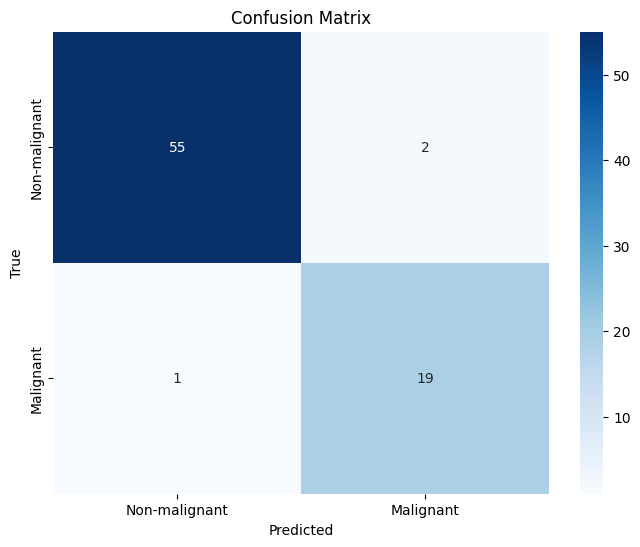

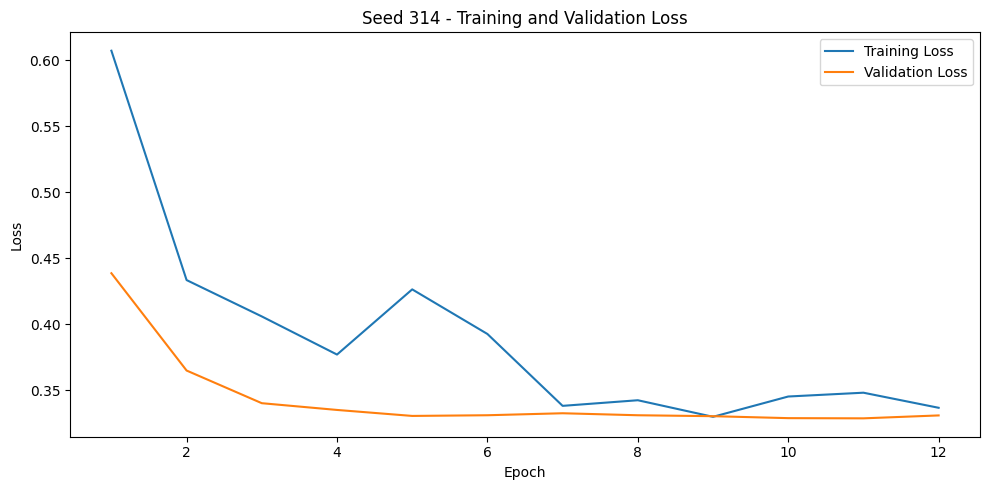


🔁 Running experiment with seed: 2024


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7697, Val Acc=1.0000, Val F1=1.0000
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 2: Train Acc=0.8989, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 3: Train Acc=0.9326, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 4: Train Acc=0.9354, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 5: Train Acc=0.9410, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 6: Train Acc=0.9298, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 7: Train Acc=0.9242, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 8: Train Acc=0.9382, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 9: Train Acc=0.9354, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9382, Val Acc=1.0000, Val F1=1.0000


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9438, Val Acc=1.0000, Val F1=1.0000
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Accuracy: 0.9610
Precision: 0.9435
Recall: 0.9575
F1 Score: 0.9501
AUC-ROC: 0.9816


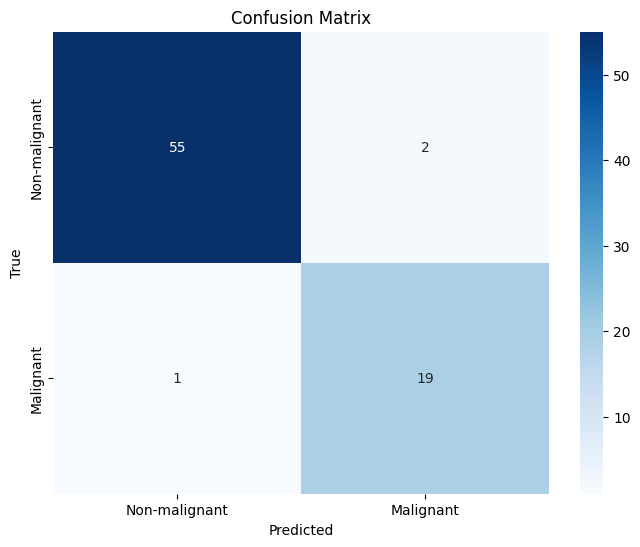

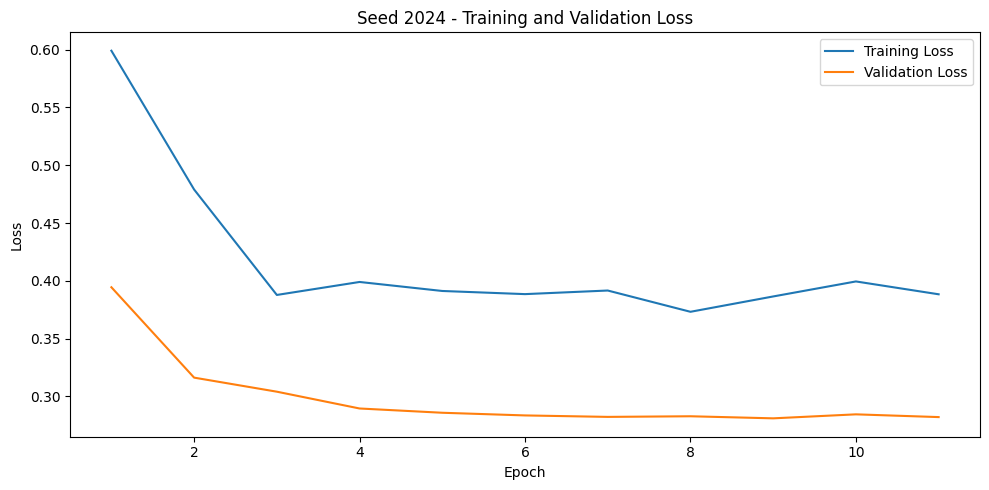


🔁 Running experiment with seed: 123


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7528, Val Acc=0.9740, Val F1=0.9662
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 2: Train Acc=0.9073, Val Acc=0.9870, Val F1=0.9834
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 3: Train Acc=0.9101, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 4: Train Acc=0.9551, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 5: Train Acc=0.9326, Val Acc=0.9610, Val F1=0.9516


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 6: Train Acc=0.9551, Val Acc=0.9610, Val F1=0.9516


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 7: Train Acc=0.9242, Val Acc=0.9870, Val F1=0.9834


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 8: Train Acc=0.9466, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 9: Train Acc=0.9326, Val Acc=0.9610, Val F1=0.9516


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 10: Train Acc=0.9466, Val Acc=0.9740, Val F1=0.9673


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 11: Train Acc=0.9326, Val Acc=0.9610, Val F1=0.9516


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 12: Train Acc=0.9522, Val Acc=0.9870, Val F1=0.9834
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Accuracy: 0.9610
Precision: 0.9348
Recall: 0.9737
F1 Score: 0.9516
AUC-ROC: 0.9947


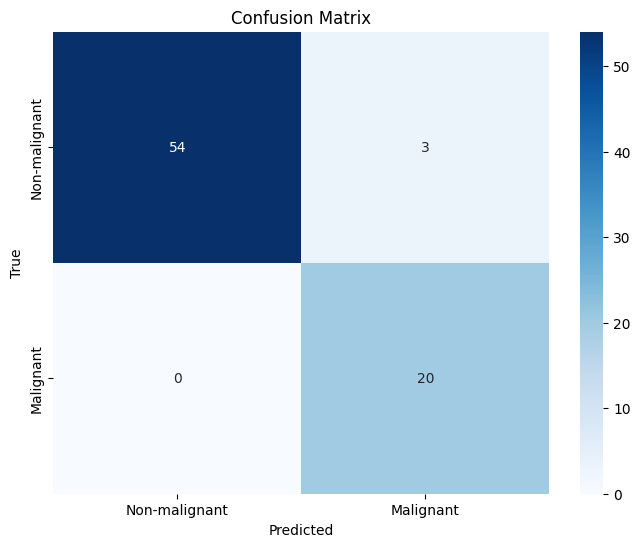

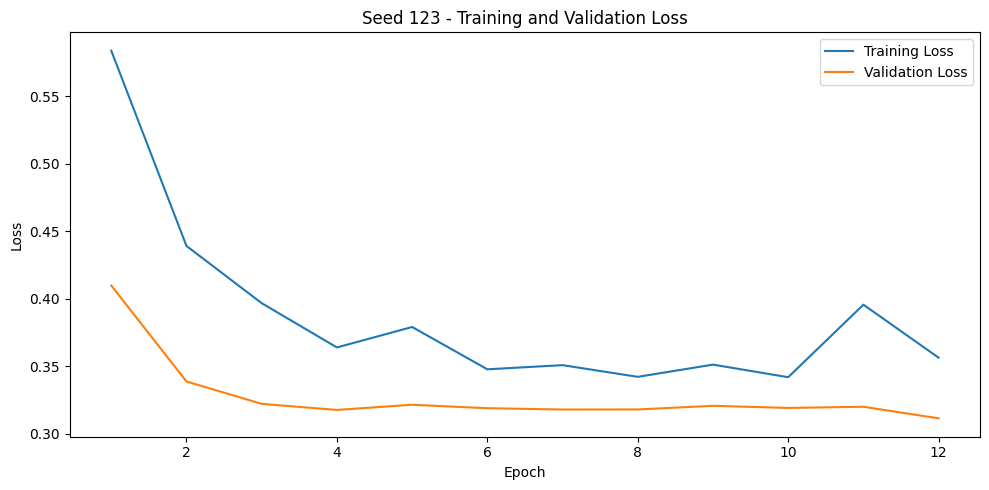


🔁 Running experiment with seed: 88


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7416, Val Acc=0.9481, Val F1=0.9345
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 2: Train Acc=0.8652, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 3: Train Acc=0.9213, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 4: Train Acc=0.9354, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 5: Train Acc=0.9466, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 6: Train Acc=0.9326, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 7: Train Acc=0.9466, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 8: Train Acc=0.9270, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 9: Train Acc=0.9494, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9410, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9242, Val Acc=0.9481, Val F1=0.9345
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Accuracy: 0.9610
Precision: 0.9348
Recall: 0.9737
F1 Score: 0.9516
AUC-ROC: 0.9982


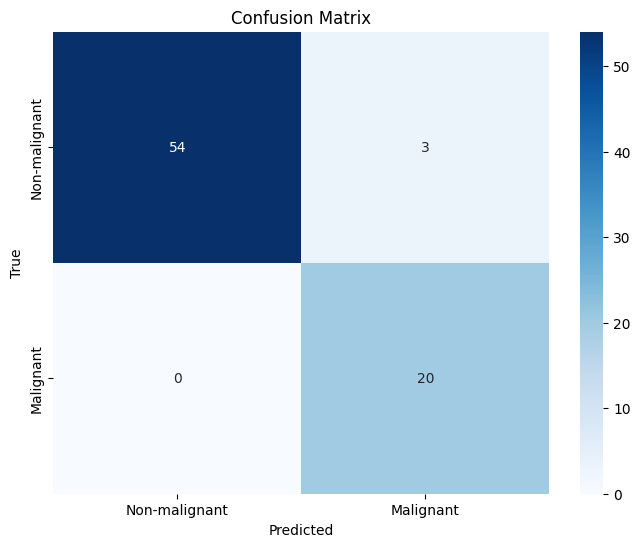

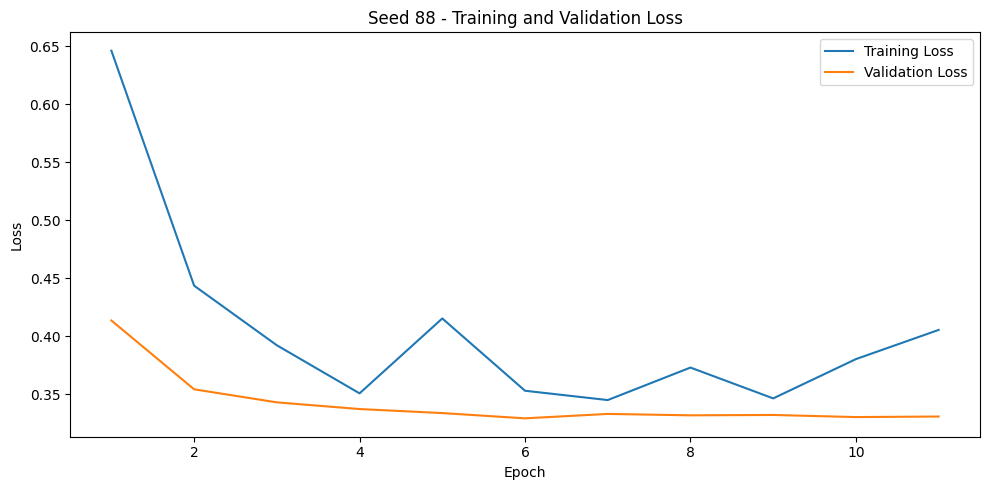


🔁 Running experiment with seed: 11


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.8118, Val Acc=0.9481, Val F1=0.9345
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 2: Train Acc=0.9185, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 3: Train Acc=0.9073, Val Acc=0.9351, Val F1=0.9193


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 4: Train Acc=0.9326, Val Acc=0.9351, Val F1=0.9193


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 5: Train Acc=0.9270, Val Acc=0.9351, Val F1=0.9193


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 6: Train Acc=0.9242, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 7: Train Acc=0.9466, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 8: Train Acc=0.9494, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 9: Train Acc=0.9438, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9522, Val Acc=0.9481, Val F1=0.9345


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 11: Train Acc=0.9494, Val Acc=0.9481, Val F1=0.9345
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Accuracy: 0.9740
Precision: 0.9545
Recall: 0.9825
F1 Score: 0.9673
AUC-ROC: 0.9956


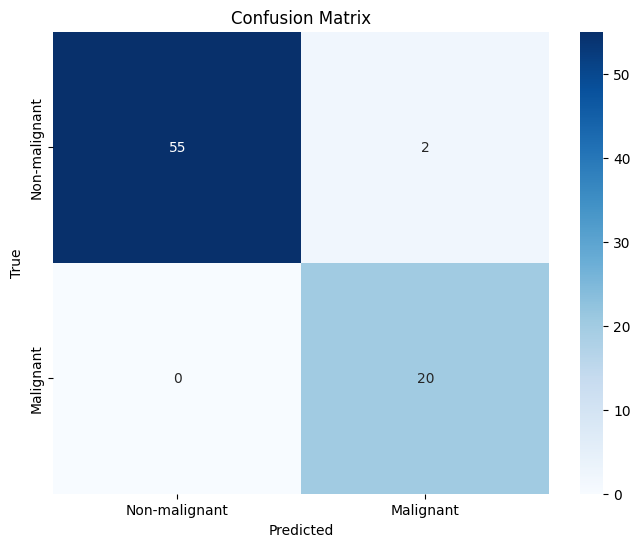

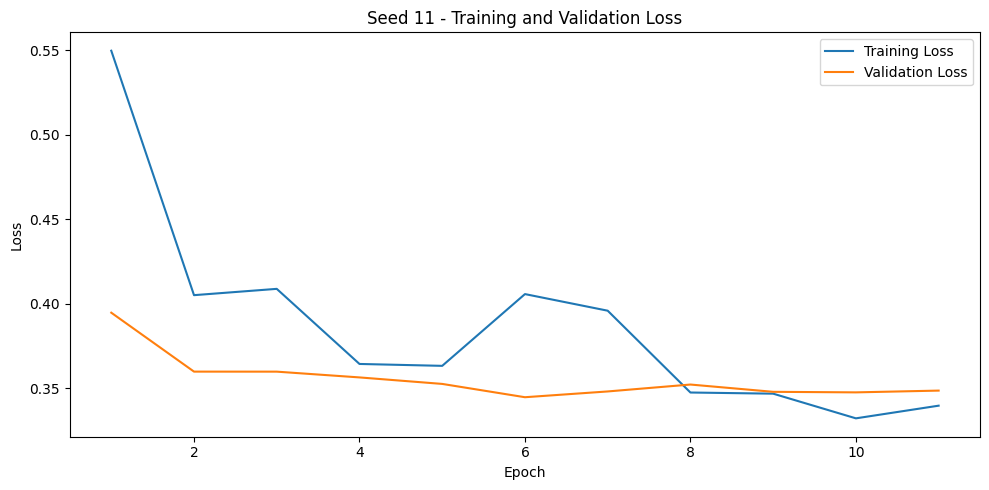


🔁 Running experiment with seed: 99


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-7c9a3dacf91b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1: Train Acc=0.7331, Val Acc=0.9351, Val F1=0.9193
✅ Improved F1. Saving model...


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 2: Train Acc=0.8792, Val Acc=0.9221, Val F1=0.9045


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 3: Train Acc=0.9213, Val Acc=0.9091, Val F1=0.8901


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch 4: Train Acc=0.9242, Val Acc=0.9221, Val F1=0.9045


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 5: Train Acc=0.9326, Val Acc=0.9221, Val F1=0.9045


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 6: Train Acc=0.9270, Val Acc=0.9221, Val F1=0.9045


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 7: Train Acc=0.9354, Val Acc=0.9221, Val F1=0.9070


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 8: Train Acc=0.9326, Val Acc=0.9091, Val F1=0.8901


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 9: Train Acc=0.9382, Val Acc=0.9221, Val F1=0.9045


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch 10: Train Acc=0.9522, Val Acc=0.9221, Val F1=0.9070


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Epoch 11: Train Acc=0.9635, Val Acc=0.9221, Val F1=0.9045
🛑 Early stopping triggered.


Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Accuracy: 0.9610
Precision: 0.9348
Recall: 0.9737
F1 Score: 0.9516
AUC-ROC: 1.0000


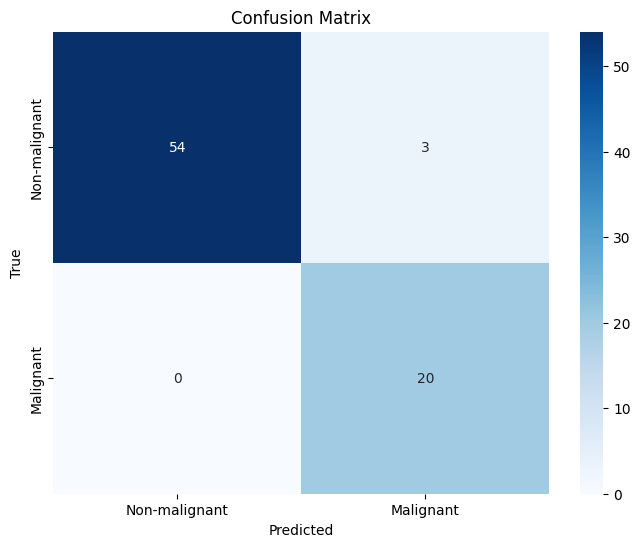

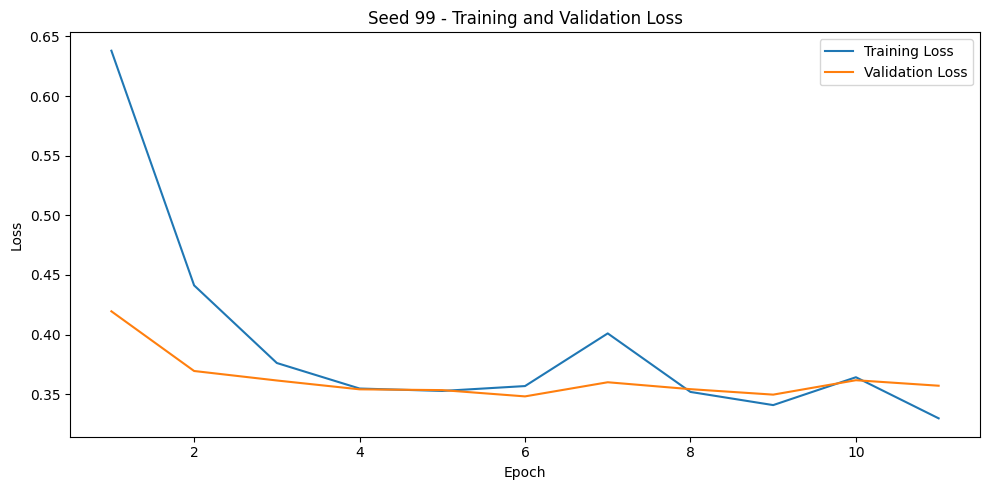

In [43]:
seed_list = [42, 77, 7, 101, 314, 2024, 123, 88, 11, 99]

test_reports, test_auc_roc = run_experiments_over_seeds_multimodal(
    seed_list=seed_list,
    texts=texts,
    images=images,
    labels=labels,
    train_transform=train_transform,
    val_test_transform=val_test_transform,
    resnet_weight_path=resnet_weight_path,
    deit_weight_path=resnet_weight_path,
    bert_weight_path=bert_weight_path,
    fc_network=fc_network,
    class_weights_tensor=class_weights_tensor
)

## Results

In [ ]:
def bootstrap_ci(data, n_bootstrap=10000, ci=95):
    data = np.array(data)
    means = []
    n = len(data)
    if n == 0:
        return np.nan, np.nan, np.nan
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return np.mean(means), lower, upper

def analyze_multimodal_results(test_reports, test_auc_roc):
    macro_f1_scores = []
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    auc_roc_scores = test_auc_roc  # Directly assign if already a list

    # Extract metrics from classification reports
    for report in test_reports:
        macro_f1_scores.append(report["macro avg"]["f1-score"])
        macro_precisions.append(report["macro avg"]["precision"])
        macro_recalls.append(report["macro avg"]["recall"])
        accuracies.append(report["accuracy"])

    print("===== Individual Seed Run Results =====")
    for i, (acc, f1, prec, rec, roc_auc) in enumerate(zip(accuracies, macro_f1_scores, macro_precisions, macro_recalls, auc_roc_scores), 1):
        print(f"Seed Run {i}:")
        print(f"  Accuracy        : {acc:.4f}")
        print(f"  Macro F1-score  : {f1:.4f}")
        print(f"  Macro Precision : {prec:.4f}")
        print(f"  Macro Recall    : {rec:.4f}")
        print(f"  AUC-ROC         : {roc_auc:.4f}")
        print()

    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Accuracy': accuracies,
        'Precision': macro_precisions,
        'Recall': macro_recalls,
        'F1-Score': macro_f1_scores,
        'AUC-ROC': auc_roc_scores
    })

    # Define which metrics to compute bootstrap CI for
    metrics_to_bootstrap = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

    # Compute summary statistics and CIs
    summary_rows = []
    for metric in metrics_to_bootstrap:
        mean_val = metrics_df[metric].mean()
        std_val = metrics_df[metric].std()
        boot_mean, ci_lower, ci_upper = bootstrap_ci(metrics_df[metric].dropna().values)

        summary_rows.append({
            'Metric': metric,
            'Mean': mean_val,
            'Std Dev': std_val,
            'Boot Mean': boot_mean,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        })

    summary_df = pd.DataFrame(summary_rows)

    print("---")
    print("===== Aggregated Results (Mean ± Std & Bootstrap 95% CI) =====")
    for _, row in summary_df.iterrows():
        print(f"{row['Metric']}:")
        print(f"  Mean ± Std       : {row['Mean']:.4f} ± {row['Std Dev']:.4f}")
        print(f"  95% CI (Bootstrap): [{row['95% CI Lower']:.4f}, {row['95% CI Upper']:.4f}]")
        print()

    return summary_df

In [44]:
analyze_multimodal_results(test_reports, test_auc_roc)

===== Individual Seed Run Results =====
Seed Run 1:
  Accuracy        : 1.0000
  Macro F1-score  : 1.0000
  Macro Precision : 1.0000
  Macro Recall    : 1.0000
  AUC-ROC         : 1.0000

Seed Run 2:
  Accuracy        : 0.9610
  Macro F1-score  : 0.9501
  Macro Precision : 0.9435
  Macro Recall    : 0.9575
  AUC-ROC         : 0.9965

Seed Run 3:
  Accuracy        : 0.9351
  Macro F1-score  : 0.9142
  Macro Precision : 0.9215
  Macro Recall    : 0.9075
  AUC-ROC         : 0.9851

Seed Run 4:
  Accuracy        : 0.9610
  Macro F1-score  : 0.9501
  Macro Precision : 0.9435
  Macro Recall    : 0.9575
  AUC-ROC         : 0.9930

Seed Run 5:
  Accuracy        : 0.9610
  Macro F1-score  : 0.9501
  Macro Precision : 0.9435
  Macro Recall    : 0.9575
  AUC-ROC         : 0.9939

Seed Run 6:
  Accuracy        : 0.9610
  Macro F1-score  : 0.9501
  Macro Precision : 0.9435
  Macro Recall    : 0.9575
  AUC-ROC         : 0.9816

Seed Run 7:
  Accuracy        : 0.9610
  Macro F1-score  : 0.9516
  Macr

,Metric,Mean,Std Dev,Boot Mean,95% CI Lower,95% CI Upper
0,Accuracy,0.963636,0.015965,0.963647,0.954545,0.974026
1,Precision,0.945421,0.021053,0.945369,0.935189,0.959550
2,Recall,0.964079,0.024236,0.964124,0.948947,0.976842
3,F1-Score,0.953679,0.020963,0.953759,0.941497,0.966779
4,AUC-ROC,0.993860,0.006091,0.993889,0.990088,0.997105
